 # eTransafe PSUR drugs Heatmap

Analyze the occurrence of various PSUR drugs in the various databases
1. authenticate with the eTransafe keycloak
2. Translate the provided compounds to SMILES
4. Retrieve data from the preclinical and clinical databases
5. Aggregate the data per system organ class
6. Visualize the data using a heatmap

(C) 2021 Erasmus University Medical Center, Rotterdam, The Netherlands
Author: Erik M. van Mulligen, e.vanmulligen@erasmusmc.nl

In [1]:
from knowledgehub.api import KnowledgeHubAPI
import ipywidgets as w
from IPython.display import display, Javascript
from ipypublish import nb_setup
import numpy as np
import numpy.ma as ma
import seaborn as sns
import pandas
from matplotlib.colors import LogNorm, Normalize
import matplotlib.pyplot as plt

In [2]:
#api = KnowledgeHubAPI(server='TEST', client_secret='39c644b3-1f23-4d94-a71f-e0fb43ebd760')
api = KnowledgeHubAPI(server='DEV', client_secret='3db5a6d7-4694-48a4-8a2e-e9c30d78f9ab')

# 1. Authentication
Use eTransafe's authentication service to get access to available services

In [3]:
username = w.Text(value='erik.mulligen',placeholder='Knowledge Hub account', description='username:', disabled=False)
password = w.Password(value='', placeholder='Knowledge Hub password', description='password:', disabled=False)
loginBtn = w.Button(description='Login')
status = w.Output()

def on_button_clicked(_):
    if api.login(username.value, password.value) == False:
        print("Failed to login")
    else:
        print("successfully logged in")
        display(Javascript('IPython.notebook.execute_cell_range(IPython.notebook.get_selected_index()+1, IPython.notebook.get_selected_index()+2)'))

loginBtn.on_click(on_button_clicked)
w.VBox([username, password, loginBtn])

successfully logged in


<IPython.core.display.Javascript object>

## 2. Translate PSUR compounds to SMILES using semantic services
For the entered compound name, retrieve the associated SMILES using the semantic services

In [4]:
psurNames = ['Cloxazolam', 'Cerivastatin', 'Bicalutamide', 'Anastrozole', 'Ulobetasol Propionate',
                 'Picoplatin', 'Vandetanib', 'Letrozole', 'Rosuvastatin', 'Vatalanib', 'Sorafenib', 'TANOMASTAT',
                 'Carvedilol', 'Saquinavir', 'Fluvastatin', 'Oxcarbazepine', 'Nilotinib', 'Fingolimod', 'Imatinib',
                 'Ciclosporin', 'Zoledronic acid', 'Tembotrione', 'Isoxaflutole', 'Roaccutan', 'Licarbazepine', 'Rimonabant',
                 'Itraconazole', 'Liarozole', 'Halometasone', 'Doramapimod', 'Denagliptin', 'Triclabendazole', 'Amodiaquine',
                 'Clarithromycin', 'Telithromycin', 'Amiodarone', 'Piboserod', 'Levofloxacin', 'Riluzole', 'Osanetant', 
                 'Aminoglutethimide', 'Netupitant']
compounds = []

for compoundName in psurNames:
    compoundSmile = api.ChemistryService().getSMILESByName(compoundName)
    if len(compoundSmile) == 1 and compoundSmile[0] is not None:
        compounds.append({'name': compoundName, 'smiles': compoundSmile[0]})
    else:
        print(f'could not find smiles for {compoundName}')

could not find smiles for Picoplatin
could not find smiles for Roaccutan


# 3. Retrieve data from the preclinical and clinical databases

In [7]:
studies = []
medline_studies = []
faers_studies = []
ct_studies = []
et_studies = []
size = 40

for c in range(0, len(compounds), size):
#    medline_studies += api.Medline().getStudiesBySMILES([c['smiles'] for c in compounds[c:c+size]])
#    print(f'{len(medline_studies)} Medline studies')
#    faers_studies += api.Faers().getStudiesBySMILES([c['smiles'] for c in compounds[c:c+size]])
#    print(f'{len(faers_studies)} FAERS studies')
    ct_studies += api.ClinicalTrials().getStudiesBySMILES([c['smiles'] for c in compounds[c:c+size]])
    print(f'{len(ct_studies)} CT studies')
#     et_studies += api.eToxSys().getStudiesByCompoundNames([c['name'] for c in compounds[c:c+size]])
#     print(f'Found {len(et_studies)} ET studies.')
    
# studies = medline_studies + faers_studies + ct_studies + et_studies


543 Medline studies
1519 FAERS studies
8154 CT studies
1728 Medline studies
3522 FAERS studies
45896 CT studies
2261 Medline studies
5685 FAERS studies
47160 CT studies
7531 Medline studies
10801 FAERS studies
92109 CT studies
7805 Medline studies
11447 FAERS studies
94708 CT studies
7807 Medline studies
11449 FAERS studies
94708 CT studies
11568 Medline studies
13419 FAERS studies
95919 CT studies
12194 Medline studies
14387 FAERS studies
97113 CT studies


# 5. Aggregate the data per system organ class

Since the eTox data reports events with an organ. We use our own method to map it to MedDRA's system organ class to make it comparable

In [49]:
system = {}
all_compounds = [compound['name'].lower() for compound in compounds]
socs = {}
count = 0
size = 10000

for i in range(0, len(studies), size):
    print(f'processing study {i}-{i+size} of {len(studies)}')
    api.SemanticService().getSocs(studies[i:i+size])


for study in studies:
    soc = study['FINDING']['__soc']
    if soc not in socs:
        socs[soc] = study['FINDING']['count']
    else:
        socs[soc] += study['FINDING']['count']

# sort the socs per count
all_socs = {k: v for k, v in sorted(socs.items(), key=lambda item: item[1], reverse=True)}


# traverse all studies and create a matrix per source
for study in studies:
    source = study['source']
    if not source in system.keys():
        system[source] = {'data':np.zeros((len(all_socs),len(all_compounds)), dtype=int).tolist(), 
                          'rows':list(all_socs.keys()), 
                          'cols':all_compounds}
    
    if object is not None:
        soc = study['FINDING']['__soc']
        row = system[source]['rows'].index(soc)
        col = system[source]['cols'].index(study['COMPOUND']['name'].lower())
        system[source]['data'][row][col] += study['FINDING']['count']
                

processing study 0-10000 of 123694
processing study 10000-20000 of 123694
processing study 20000-30000 of 123694
processing study 30000-40000 of 123694
processing study 40000-50000 of 123694
processing study 50000-60000 of 123694
processing study 60000-70000 of 123694
processing study 70000-80000 of 123694
processing study 80000-90000 of 123694
processing study 90000-100000 of 123694
processing study 100000-110000 of 123694
processing study 110000-120000 of 123694
processing study 120000-130000 of 123694


ValueError: 'imatinib' is not in list

# 6. Visualize the data using a heatmap

Using seaborn to visualize the content of the various databases. Note that we have to think about ways to easier compare the various results.

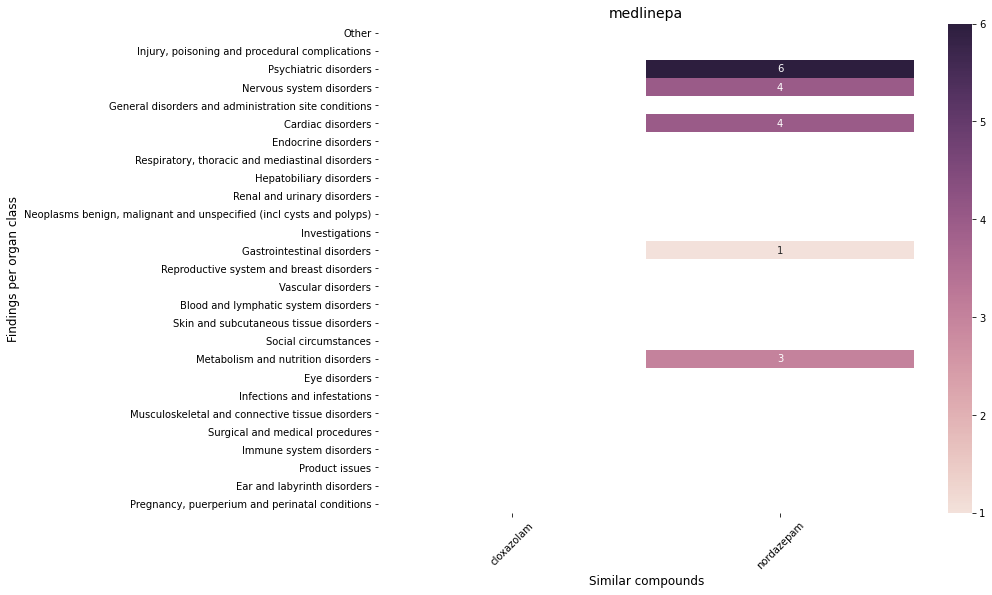

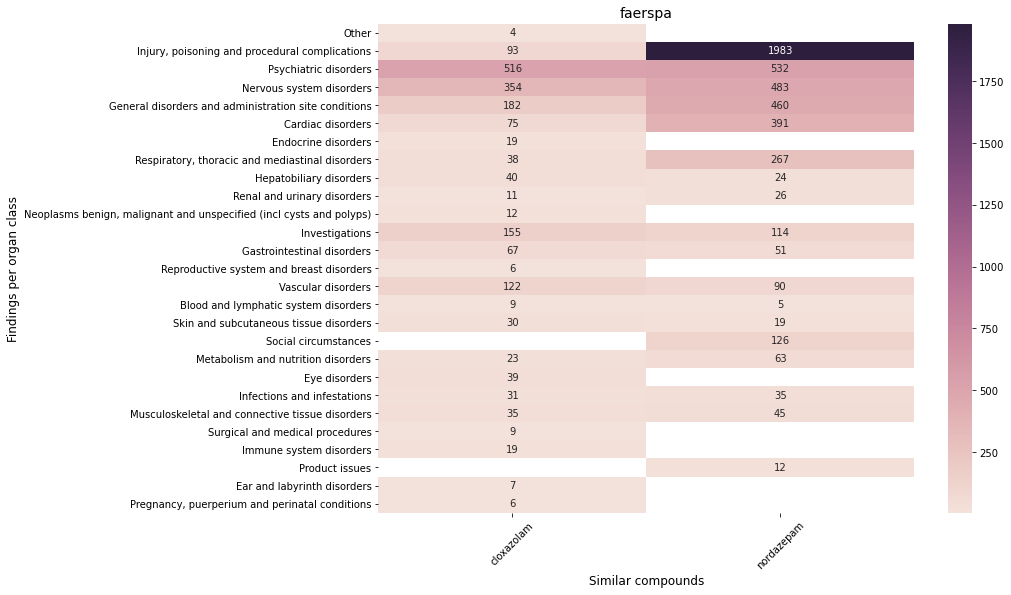

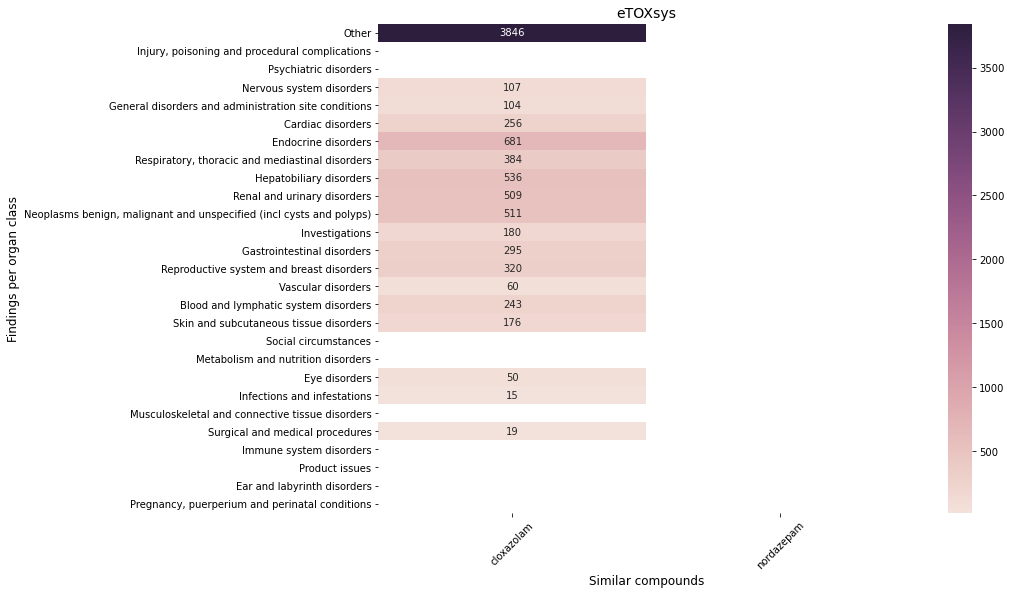

In [13]:
i = 1
for source,value in system.items():
    plt.figure(figsize=(12,9))
    data = system[source]['data']
    
    # create mask
    data_mask = ma.array(np.zeros((len(all_socs.keys()), len(all_compounds))))
    for r in range(0, len(all_socs.keys())):
        for c in range(0, len(all_compounds)):
            data_mask[r][c] = 1 if data[r][c] == 0 else 0

    colormap = sns.cubehelix_palette(as_cmap=True, light=.9)
    ax = sns.heatmap(data, mask=data_mask, xticklabels=all_compounds, yticklabels=list(all_socs.keys()), annot=True, fmt=".0f", cmap=colormap) 
    ax.set_xticklabels(ax.get_xmajorticklabels(), rotation=45)
    plt.title(source, fontsize = 14)
    plt.ylabel("Findings per organ class", fontsize = 12)
    plt.xlabel("Similar compounds", fontsize = 12)
    plt.show()

    i += 1
    print('')
    print('')
